In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

pd.set_option('max_columns', 8, 'max_rows', 10)

# Auctions Ventana 1

In [ ]:
# Leo el .csv, ordeno por fecha
auctions = pd.read_csv('data/auctions_ventanas/auctions_2019-04-18-2019-04-20.csv', low_memory=False, parse_dates=['date'])
auctions = auctions.sort_values(by='date')
auctions.head()

## Feature engineering

In [2]:
def is_easter_holiday(x):
    if x.day == 18 or x.day == 19 or x.day == 20 or x.day == 21:
        return 1
    else:
        return 0

In [3]:
y = set()
def is_new_device(x):
    if x in y:
        return 0
    else:
        y.add(x)
        return 1

In [4]:
def is_early_morning(x):
    if x.hour >= 3 and x.hour <= 7:
        return 1
    else:
        return 0

In [5]:
def is_late_evening(x):
    if x.hour >= 20:
        return 1
    else:
        return 0

In [ ]:
auctions['hour'] = auctions['date'].dt.hour.astype(np.int8)
auctions['early_morning'] = auctions['date'].map(is_early_morning).astype(np.int8)
auctions['late_evening'] = auctions['date'].map(is_late_evening).astype(np.int8)
auctions['weekday'] = auctions['date'].dt.weekday.astype(np.int8)
auctions['weekend'] = (auctions['weekday'] >= 5).astype(np.int8)
auctions['easter_holiday'] = auctions['date'].map(is_easter_holiday).astype(np.int8)
auctions['days_elapsed_since_window_start'] = (auctions['date'] - pd.Timestamp('2019-04-18 00:00:00')).astype('timedelta64[D]')
auctions['auction_number_since_window_start'] = np.arange(len(auctions))
auctions['new_device_id_since_window_start'] = auctions['device_id'].map(is_new_device).astype(np.int8)

## Cálculo de labels

In [ ]:
# device_id es ref_hash, me quedo con el primer registro (primera fecha) donde aparezca cada hash
auctions = auctions.rename(index=str, columns={'device_id' : 'ref_hash'})
auctions = auctions.drop_duplicates(subset='ref_hash')
auctions = auctions.set_index('ref_hash')
auctions

In [ ]:
# Ya tengo la fecha mínima para cada ref_hash, resto el momento inicial y convierto a segundos
auctions['date'] = auctions['date'] - pd.Timestamp('2019-04-18 00:00:00')
auctions['date'] = auctions['date'].map(lambda x: x.total_seconds())
auctions = auctions.rename(index=str, columns={'date' : 'time_first_ocurrence_since_window_start'})
auctions

## Entrenamiento y predicción del modelo

In [ ]:
features = auctions.drop('time_first_ocurrence_since_window_start', axis=1)
labels = auctions['time_first_ocurrence_since_window_start']
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.2, random_state=123)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

## Chequeo de resultados

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

In [ ]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

# Generalización para cualquier ventana

In [12]:
def create_labels(time_window_df, start_date):
    # device_id es ref_hash, me quedo con el primer registro (primera fecha) donde aparezca cada hash
    time_window_df = time_window_df.rename(index=str, columns={'device_id' : 'ref_hash'})
    time_window_df = time_window_df.drop_duplicates(subset='ref_hash')
    time_window_df = time_window_df.set_index('ref_hash')
    
    # Ya tengo la fecha mínima para cada ref_hash, resto el momento inicial y convierto a segundos
    time_window_df['date'] = time_window_df['date'] - pd.Timestamp(start_date)
    time_window_df['date'] = time_window_df['date'].map(lambda x: x.total_seconds())
    time_window_df = time_window_df.rename(index=str, columns={'date' : 'time_first_ocurrence_since_window_start'})
    return time_window_df

In [16]:
def calculate_labels(filename, start_date):
    # Leo el .csv, ordeno por fecha
    auctions = pd.read_csv(filename, low_memory=False, parse_dates=['date'])
    auctions = auctions.sort_values(by='date')  
    return create_labels(auctions, start_date)

In [8]:
def add_features(time_window_df, start_date):
    time_window_df['hour'] = time_window_df['date'].dt.hour.astype(np.int8)
    time_window_df['early_morning'] = time_window_df['date'].map(is_early_morning).astype(np.int8)
    time_window_df['late_evening'] = time_window_df['date'].map(is_late_evening).astype(np.int8)
    time_window_df['weekday'] = time_window_df['date'].dt.weekday.astype(np.int8)
    time_window_df['weekend'] = (time_window_df['weekday'] >= 5).astype(np.int8)
    time_window_df['easter_holiday'] = time_window_df['date'].map(is_easter_holiday).astype(np.int8)
    time_window_df['days_elapsed_since_window_start'] = (time_window_df['date'] - pd.Timestamp(start_date)).astype('timedelta64[D]')
    time_window_df['auction_number_since_window_start'] = np.arange(len(time_window_df))
    time_window_df['new_device_id_since_window_start'] = time_window_df['device_id'].map(is_new_device).astype(np.int8)

In [13]:
def process_time_window(filename, start_date):
    # Leo el .csv, ordeno por fecha
    auctions = pd.read_csv(filename, low_memory=False, parse_dates=['date'])
    auctions = auctions.sort_values(by='date')
    
    add_features(auctions, start_date)
    auctions = create_labels(auctions, start_date)
    return auctions

In [14]:
auctions1 = process_time_window('data/auctions_ventanas/auctions_2019-04-18-2019-04-20.csv', '2019-04-18 00:00:00')
auctions1

,time_first_ocurrence_since_window_start,ref_type_id,source_id,hour,...,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start,new_device_id_since_window_start
ref_hash,,,,,,,,,
1826643666390887030,0.015050,7,0,0,...,1,0.0,0,0
7037174172278258682,0.029014,1,0,0,...,1,0.0,1,0
3392065368947589877,0.057540,1,1,0,...,1,0.0,2,0
1228982273563226229,0.126828,1,1,0,...,1,0.0,3,0
4123059034628125459,0.132510,1,8,0,...,1,0.0,4,0
...,...,...,...,...,...,...,...,...,...
3249485961899571550,259196.265259,7,1,23,...,1,2.0,15644489,0
6935058777451259898,259196.949571,1,1,23,...,1,2.0,15644543,0
4775315369292092311,259197.827543,1,0,23,...,1,2.0,15644607,0


In [17]:
auctions2 = calculate_labels('data/auctions_ventanas/auctions_2019-04-21-2019-04-23.csv', '2019-04-21 00:00:00')
auctions2

,time_first_ocurrence_since_window_start,ref_type_id,source_id
ref_hash,,,
5733927591955330573,0.004920,1,1
8906329411852863929,0.007056,1,3
4823921476577985805,0.017098,1,1
1118383901220956279,0.032361,1,3
2052804935692491509,0.042073,1,0
...,...,...,...
2785513434268571528,259194.216258,1,0
8563931940602405138,259194.330805,1,1
5238056528975163131,259195.049895,1,3


In [18]:
labels1 = auctions1['time_first_ocurrence_since_window_start']
labels2 = auctions2['time_first_ocurrence_since_window_start']
merged = pd.merge(left=labels1, right=labels2, how='left', left_index=True, right_index=True)
merged['time_first_ocurrence_since_window_start_y'] = merged['time_first_ocurrence_since_window_start_y'].fillna(3*24*60*60)
merged

,time_first_ocurrence_since_window_start_x,time_first_ocurrence_since_window_start_y
ref_hash,,
1826643666390887030,0.015050,75658.343525
7037174172278258682,0.029014,135.824498
3392065368947589877,0.057540,234266.865041
1228982273563226229,0.126828,2363.081608
4123059034628125459,0.132510,147350.860399
...,...,...
3249485961899571550,259196.265259,90.083342
6935058777451259898,259196.949571,3.738379
4775315369292092311,259197.827543,15640.008751


In [19]:
merged.isnull().any()

time_first_ocurrence_since_window_start_x    False
time_first_ocurrence_since_window_start_y    False
dtype: bool

In [22]:
features = auctions1
labels = merged['time_first_ocurrence_since_window_start_y']
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.2, random_state=123)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [23]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
ref_hash,,
2231822616694586144,103741.700022,100403.957089
2750933040934976444,259200.000000,131793.891470
4149242630324626077,259200.000000,83021.266293
3136261927697504701,94281.199463,145474.074161
127114261016544666,28.696660,85784.558779
...,...,...
2716906771211791137,188512.790241,83357.675229
1948110898567524593,19030.774288,117113.161465
90598478072557049,45004.177718,87528.427997


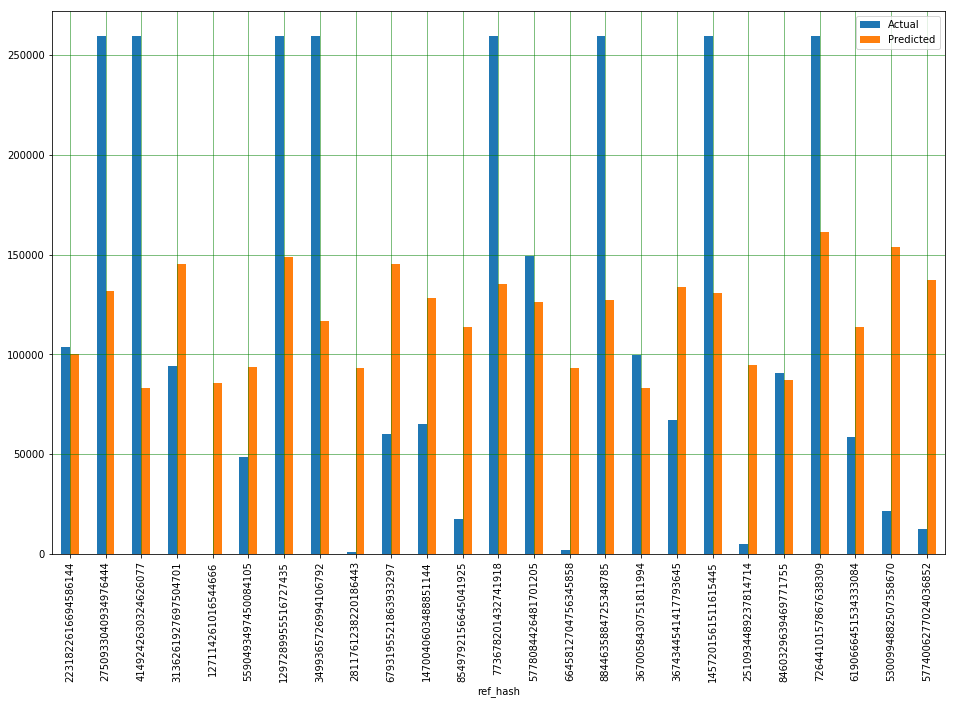

In [24]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 91157.60625127384
Mean Squared Error: 10224312037.248865
Root Mean Squared Error: 101115.34026669181
R2 Score: 0.04429481671626889


## Exportar los resultados

In [ ]:
target = pd.read_csv('data/target_competencia_ids.csv', low_memory=False)
target['ref_hash'] = target['ref_hash'].map(lambda x: x.split('_')[0]).astype(np.int64)
target = target.drop_duplicates(subset='ref_hash')
target

In [ ]:
output = pd.Series(data = y_pred, index = X_test.index, name = 'pred')
output = output.reset_index()
output

In [ ]:
output = output.merge(target_hash, on='ref_hash', how='right')
output = output.fillna(3*24*60*60)
#output.to_csv("auctions_linear.csv", index=False)
output